# Impact of rainfall temporal distribution on flooding in Lin Dyke catchment


## Project Summary

Research suggests that the temporal distribution of rainfall within a storm event can influence the nature and severity of flooding resulting from that storm event....

Testing this using synthetic rainfall events derived from FEH/ReFH2. Standard profiles usually have one peak, testing three methods for splitting the total rainfall amount normally concentrated in this one peak into multiple peaks 

Analysing impact on the extent, depth and velocity of flooding, and the spatial distribution of these variables over the catchment

### Code initialisation

In [12]:
import rasterio
import rioxarray as rxr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import pyplot
from matplotlib.patches import Patch
from matplotlib.ticker import PercentFormatter
import matplotlib.ticker as mtick
import os
import fiona
import rasterio.plot
import matplotlib as mpl
from rasterio.plot import show
from rasterio.plot import show_hist
from rasterio.mask import mask
from shapely.geometry import box
import geopandas as gpd
from fiona.crs import from_epsg
import pycrs
from pyproj import CRS
# from descartes import PolygonPatch
from PIL import Image
import matplotlib.colors as colors
from mycolorpy import colorlist as mcp
import matplotlib.patches as mpatches
import contextily as cx
import geopandas as gpd
import numpy.ma as ma
import itertools

from my_functions import *

# os.chdir("../../../FloodModelling")

# Define whether to filter out values <0.1
remove_little_values = True

In [9]:
### Define the names of the methods, and the shorthand versions of the names used in the folder naming conventions
rainfall_scenario_names =  {'singlepeak' : 'sp', 'dividetime' : 'dt', 'subpeaktiming' : 'sp-t', 'maxspread': 'ms'}

In [10]:
breaks_difference = np.array([-0.1, 0.1, 0.3, 100])

In [19]:
def create_binned_counts_and_props(rainfall_scenario_names, variable_name, breaks, labels, remove_little_values = True):
    # Create dataframes to populate with values
    counts_df = pd.DataFrame()
    proportions_df = pd.DataFrame()        

    # Loop through each rainfall scenario
    # Get the raster containing its values, and count the number of each unique value, and construct into a dataframe
    for rainfall_scenario_name, rainfall_scenario_shortening in rainfall_scenario_names.items():  
        raster = prepare_rainfall_scenario_raster(variable_name, rainfall_scenario_name, rainfall_scenario_shortening, remove_little_values)[0]
        unique, counts = np.unique(raster, return_counts=True)
        df = pd.DataFrame({'values': unique, 'counts':counts})

        # Add a new column specifying the bin which each value falls within
        df['bins']= pd.cut(unique, bins=breaks, right=False)
        
        # Create a new dataframe showing the number of cells in each of the bins
        groups = df.groupby(['bins']).sum()
        groups  = groups.reset_index()
        
        # Find the total number of cells
        total_n_cells = groups ['counts'].sum()
        # Find the number of cells in each group as a proportion of the total
        groups['Proportion'] = round((groups['counts']/total_n_cells) *100,1)
        
        # Add values to dataframes
        counts_df[rainfall_scenario_name] = groups['counts']
        proportions_df[rainfall_scenario_name] = groups['Proportion']
        
    # Reset index to show the groups
    counts_df.reset_index(inplace=True)
    proportions_df.reset_index(inplace=True)
    
    # Set index values
    counts_df['index'] = labels
    proportions_df['index'] = labels

    return counts_df, proportions_df
    


In [20]:
# Define breaks to split the depths/velocities on
breaks_depths = np.array([0, 0.3, 0.6, 1.2, 100])  
labels_depth = ['<=0.3m', '0.3-0.6m', '0.6-1.2m', '>1.2m']
breaks_velocity = np.array([0,0.25,0.5,2,100])
labels_velocity = ["<=0.25m/s", "0.25-0.5m/s", "0.5-2m/s", ">2m/s"]

velocity_counts, velocity_props = create_binned_counts_and_props(rainfall_scenario_names, 'velocity', breaks_velocity, labels_velocity, remove_little_values)
depth_counts, depth_props = create_binned_counts_and_props(rainfall_scenario_names, 'depth', breaks_depths, labels_depth, remove_little_values)

#  Flood extent 
To examine whether the rainfall's temporal distribution influences the total extent of flooding, the number of flooded cells and the total flooded area in km2 (incl. only cells with depth >0.1m) is compared between the profile with a single peak, and the three methods for producing multi-peaked rainfall events. 

In [21]:
# Create one dataframe with each column the total number of flooded cells for each method 
totals_df =pd.DataFrame(depth_counts.sum(numeric_only=True)).T
totals_df = totals_df.iloc[[len(totals_df)-1]]
# Convert this to the total flooded area for each method
totals_df_area = (totals_df * 25)/1000000

In [22]:
# Get a list of the percentage difference between the total number of flooded cells with a single peak and the methods for
# creating multiple peaks
ls = []
for rainfall_scenario in rainfall_scenario_names.keys():
    if rainfall_scenario!= 'singlepeak':
        ls.append((totals_df[rainfall_scenario]/totals_df['singlepeak'] - 1).values[0])
# Convert values to strings, and add a + sign for positive values
# Include an empty entry for the single peak scenario
ls =[''] + ['+' + str(round((list_item *100),2)) + '%' if list_item > 0 else str(round((list_item *100),2)) + '%'  for list_item in ls]

## Total number of flooded cells/flooded area for each rainfall distribution (depths>0.1m)
<!-- This is assuming grid cells are 5m by 5m - but need to check this is correct.  
This plot is the same whether you use depth or velocity as the variable -->

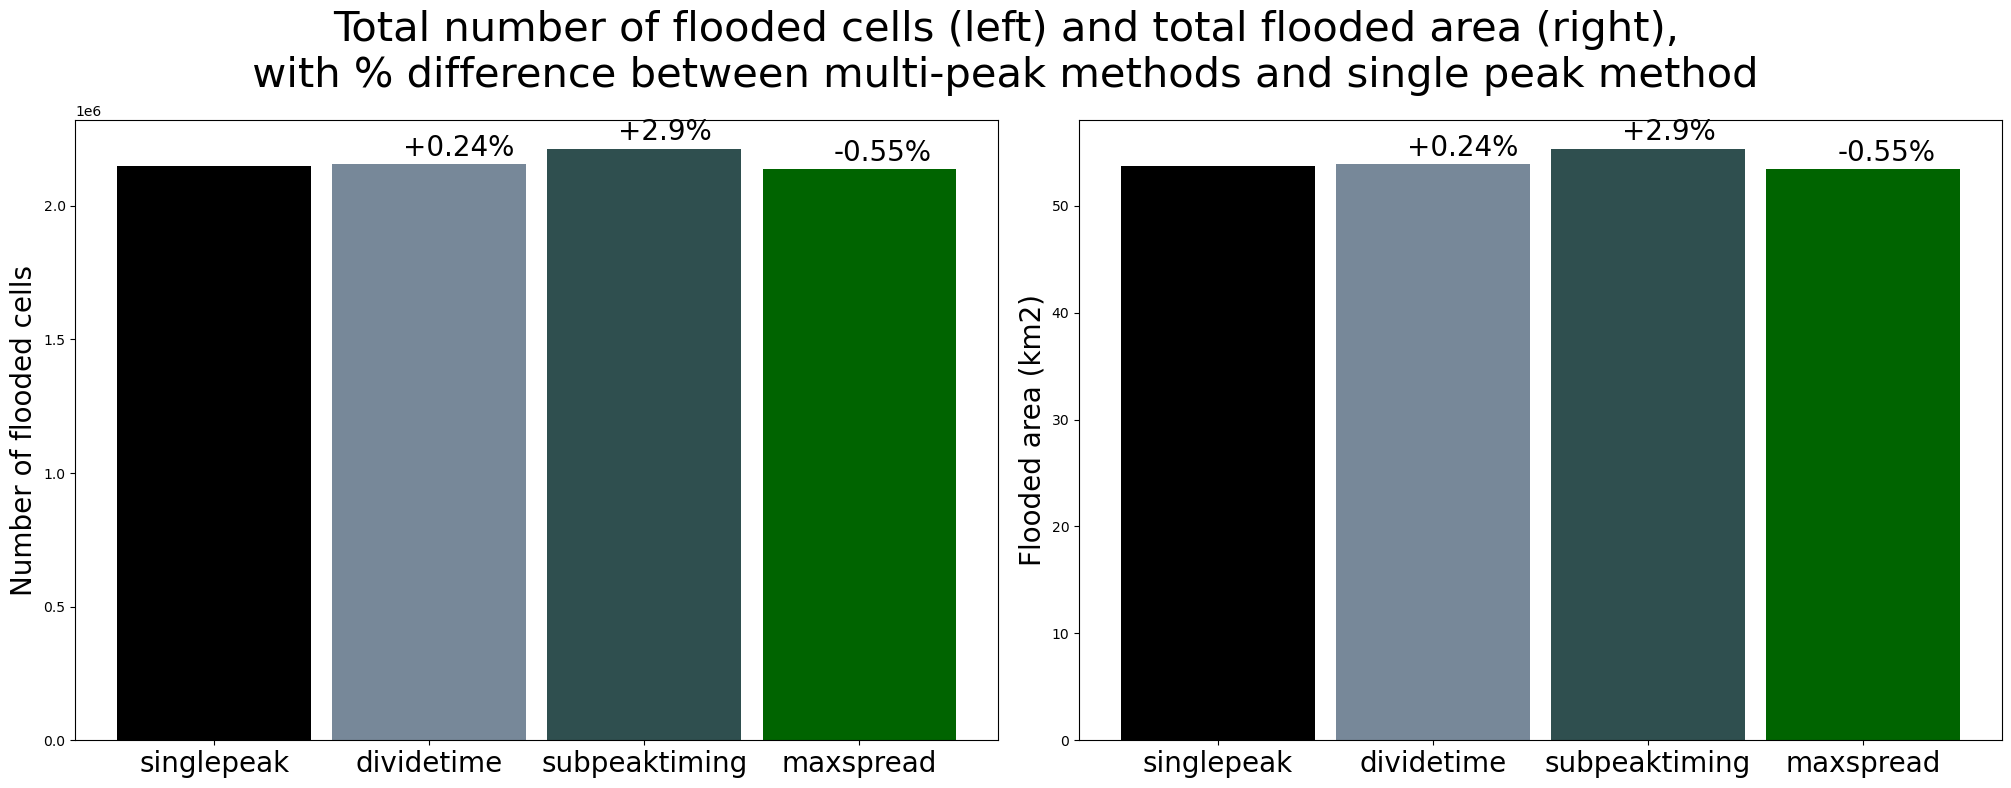

In [23]:
# Set colors for plots
colors = ['black', 'lightslategrey', 'darkslategrey', 'darkgreen']

fig, axs = plt.subplots(nrows=1, ncols=2, constrained_layout=True, figsize = (20,14))
y_pos = np.arange(len(rainfall_scenario_names.keys()))

##############################
# Plot number of flooded cells
##############################
plt.subplot(221)
plt.bar(y_pos, totals_df.iloc[[0]].values.tolist()[0], color=colors,
        width = 0.9)
# Create names on the x-axis
plt.xticks(y_pos, rainfall_scenario_names.keys(), fontsize =20)
# plt.xlabel('Method')
plt.ylabel('Number of flooded cells', fontsize =20)

xlocs, xlabs = plt.xticks()
xlocs=[i+1 for i in range(0,10)]
xlabs=[i/2 for i in range(0,10)]

for i, v in enumerate(totals_df.iloc[[0]].values.tolist()[0]):
    plt.text(xlocs[i] - 1.12, v * 1.015, str(ls[i]), fontsize = 20)

# ##############################
# # Plot flooded extent in m2
# ##############################
plt.subplot(222)
plt.bar(y_pos, totals_df_area.iloc[[0]].values.tolist()[0], color=colors,
        width = 0.9)
# Create names on the x-axis
plt.xticks(y_pos, rainfall_scenario_names.keys(), fontsize =20 )
# plt.xlabel('Method')
plt.ylabel('Flooded area (km2)', fontsize =20 )

xlocs, xlabs = plt.xticks()
xlocs=[i+1 for i in range(0,10)]
xlabs=[i/2 for i in range(0,10)]

for i, v in enumerate(totals_df_area.iloc[[0]].values.tolist()[0]):
    plt.text(xlocs[i] - 1.12, v * 1.015, str(ls[i]), fontsize = 20)

st = plt.suptitle ("Total number of flooded cells (left) and total flooded area (right),\n with % difference between multi-peak methods and single peak method ", fontsize = 30)

# Flood depth and velocity

To examine whether the rainfall's temporal distribution influences the spatial extent of flooding, the flood depths and velocities (excluding areas below 0.1m) are compared for each of the four distribution methods.  

To highlight particular areas where the rainfall distributions with multiple peaks might have led to substantially more or less flooding than the single peak method, the difference between the single peak method and each of the other three multi-peaked methods are plotted. A positive difference implies that the flooding is deeper/faster in the single peak method, whilst a negative difference implies the opposite. 

## Spatial extent of flooding, by depth category (for d >0.1m) for each rainfall distribution

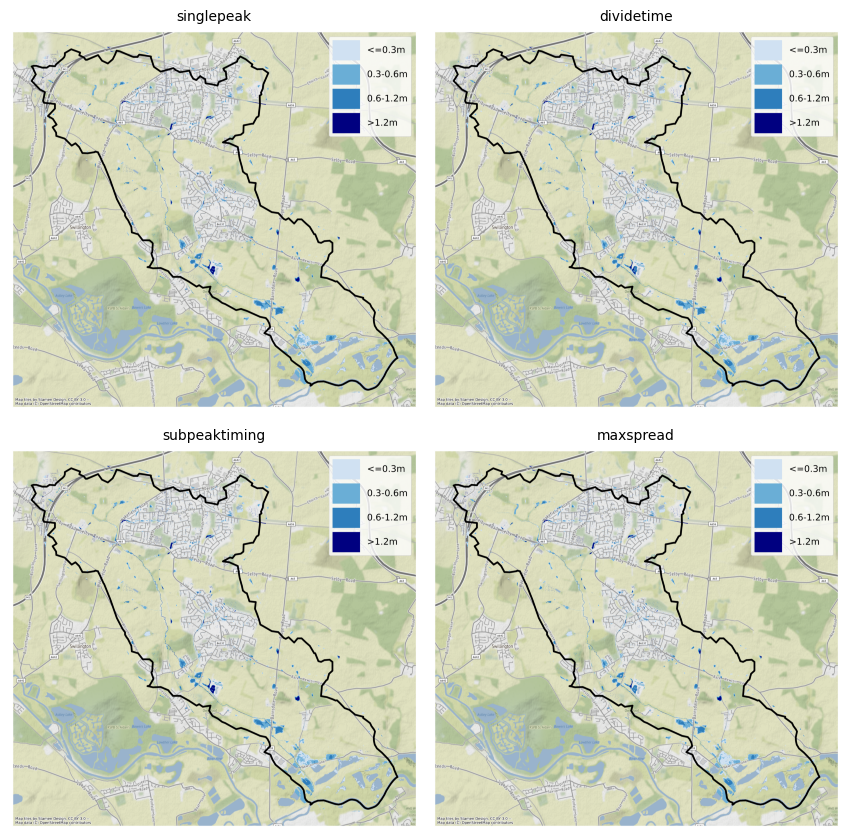

In [26]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(30,20))
subplot_n = [221, 222, 223, 224]
subplot_i = 0

for subplot_i, method in enumerate(rainfall_scenario_names):
    img = Image.open("Arcpy/Figs/depth_{}_classified.png".format(method))
    plt.subplot(subplot_n[subplot_i])
    plt.axis('off')
    plt.imshow(img)
    plt.title(method, fontsize = 10)
fig.tight_layout()
plt.subplots_adjust(left=0.125,bottom=0.1, right=0.5, top=0.5, wspace=-0.4, hspace=0.1)
# plt.show()    
plt.show()

In [25]:
# Create discrete cmap
colors_list = [mpl.cm.Blues(0.2), mpl.cm.Blues(0.5), mpl.cm.Blues(0.7),"navy"]
cmap = mpl.colors.ListedColormap(colors_list)

    
my_dict = {"dividetime":"Arcpy/depth_dividetime_reclassified.tif",
           "maxspread":"Arcpy/depth_maxspread_reclassified.tif",
           "subpeaktiming":"Arcpy/depth_subpeaktiming_reclassified.tif",
           "singlepeak": "Arcpy/depth_singlepeak_reclassified.tif"}    

plot_with_folium(my_dict, cmap, template_depth_cats)